In [ ]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import skimage.draw 
import random
# si quieres ejecutar esto en google colab para el entrenamiento(recomendado), debes actualizar la vesión del siguiente paquete:

#!pip install -U scikit-image==0.16.2 #esta versión debe resolver el problema que ocurre cuando  el tipo de imagen de entrada es bool. 
                                      # Ya que la interpolación ahora no está definida con el tipo de datos bool.

# En su momento (2021), yo no necesité actualizar el paquete, ya que todas las versiones de los paquetes en Colab eran compatibles con el modelo.
# Yo encontre esta solución, pero puede ocurrir que cuando tu lo ejecutes debas actualizar a otras versiones de algún otro paquete.

In [1]:
!git clone https://github.com/matterport/Mask_RCNN.git # puedes clonar el repositorio original de Mask RCNN donde se encuentra el modelo 
                                                       # o descargar la carpeta Mask_RCNN directamente de mi repositorio

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 16.01 MiB/s, done.
Resolving deltas: 100% (558/558), done.


# Nueva sección

In [ ]:
#Nos movemos a la siguiente carpeta:
os.chdir('/content/Mask_RCNN')

In [ ]:
!pwd # verificar en qué carpeta nos encontramos.

/content/Mask_RCNN


In [ ]:
# Se establece la ruta de la carpeta raíz donde se encuentra el modelo Mask R-CNN
ROOT_DIR = '/content/Mask_RCNN'

# Se asegura de que la carpeta raíz existe en el sistema
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist'

# Se agrega la ruta de la carpeta raíz al sys.path para permitir que los módulos de Mask R-CNN se importen correctamente
sys.path.append(ROOT_DIR) 

# Se importan los módulos y funciones necesarios de Mask R-CNN.
from mrcnn import visualize    # Módulo para visualizar los resultados de la detección de objetos
from mrcnn.config import Config    # Clase para definir la configuración del modelo, con el tiempo esta clase se acutlizó y ahora genera incompativilidades. 
from mrcnn import model as modellib, utils    # Módulo principal para construir y entrenar el modelo, y módulo de funciones útiles para manipular datos y visualización

In [ ]:
# Establece la ruta donde se guardarán los pesos y configuraciones del modelo durante el entrenamiento
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Establece la ruta para el modelo pre-entrenado Mask R-CNN para la base de datos COCO
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Si el archivo mask_rcnn_coco.h5 no existe en la carpeta raíz, se descarga automáticamente utilizando la función download_trained_weights() del módulo utils de Mask R-CNN
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
class SConfig(Config): #hay que cambiarle el nombre a esta clase
    # Nombre de la configuración
    NAME = "S"

    # Número de GPUs a usar
    GPU_COUNT = 1

    # Número de imágenes a usar por GPU
    IMAGES_PER_GPU = 1

    # Número de clases a detectar, se agrega 1 por la clase de fondo
    NUM_CLASSES = 1 + 1  

    # Se utiliza modo de redimensionamiento de imágenes a square (cuadrado)
    IMAGE_RESIZE_MODE = "square"

    # Se establece la dimensión mínima y máxima de las imágenes  # yo antes puse:  IMAGE_MIN_DIM = 320 y IMAGE_MAX_DIM = 192, es recomendable cambiar esos valores)
    IMAGE_MIN_DIM = 192
    IMAGE_MAX_DIM = 320

    # Número de pasos por época durante el entrenamiento
    STEPS_PER_EPOCH = 500

    # Número de pasos de validación durante el entrenamiento
    VALIDATION_STEPS = 5

    # Se establece el modelo de backbone como resnet50, de lo contrario se usa resnet101 por defecto
    BACKBONE = 'resnet50'

    # Se definen las escalas de anclaje de la región de interés (RPN)
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # Número de regiones de interés (ROIs) por imagen que se utilizarán durante el entrenamiento
    TRAIN_ROIS_PER_IMAGE = 32

    # Número máximo de instancias positivas que se utilizarán en una sola imagen durante el entrenamiento
    MAX_GT_INSTANCES = 50 

    # Número de regiones de interés (ROIs) después de la supresión no máxima (NMS) durante la inferencia
    POST_NMS_ROIS_INFERENCE = 500 

    # Número de regiones de interés (ROIs) después de la supresión no máxima (NMS) durante el entrenamiento
    POST_NMS_ROIS_TRAINING = 1000 
    
config = SConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  192
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

El siguiente módulo del programa contiene la definición de una clase llamada SDataset, la cual se utiliza para cargar y procesar los datos del conjunto de datos de S.

In [ ]:
# Clase que hereda de utils.Dataset de la librería Mask R-CNN
class SDataset(utils.Dataset):

    # Función para cargar el conjunto de datos de S
    def load_S(self, dataset_dir, subset):

        # Agregar la clase "S" al conjunto de datos con ID 1
        self.add_class("S", 1, "S")

        # Verificar si el conjunto de datos es de entrenamiento o validación
        assert subset in ["train", "val"] 
        dataset_dir = os.path.join(dataset_dir, subset)

         # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.

        # Cargar las anotaciones del conjunto de datos
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # Se elimina las llaves de las anotaciones

        # Filtrar las anotaciones que no tienen regiones definidas
        annotations = [a for a in annotations if a['regions']]

        # Recorrer cada anotación
        for a in annotations:
            # Obtener las regiones del objeto y la imagen correspondiente
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            # Agregar la imagen y sus anotaciones al conjunto de datos
            self.add_image(
                "S",
                image_id=a['filename'],  # usar el nombre del archivo como ID único de la imagen
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    # Función para cargar las máscaras de instancia de una imagen
    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """

        # Obtener información de la imagen
        image_info = self.image_info[image_id]
        if image_info["source"] != "S":
            return super(self.__class__, self).load_mask(image_id)

        # Crear una máscara vacía
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)

        # Generar una máscara para cada región de la imagen
        for i, p in enumerate(info["polygons"]):
            # Obtener los índices de los píxeles dentro de la región y establecerlos en 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Devolver las máscaras de instancia y sus identificadores de clase
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    # la función obtiene la información asociada a esa imagen en el conjunto de datos a través de self.image_info[image_id]
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "S":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)          

In [ ]:
# Creamos una instancia de la clase SDataset para el conjunto de entrenamiento
dataset_train = SDataset()
# Cargamos los datos de entrenamiento de la carpeta "train" dentro de la carpeta "data"
dataset_train.load_S("/content/Mask_RCNN/data", "train")
# Preparamos los datos para ser utilizados en el modelo
dataset_train.prepare()

# Creamos una instancia de la clase SDataset para el conjunto de validación
dataset_val = SDataset()
# Cargamos los datos de validación de la carpeta "val" dentro de la carpeta "data"
dataset_val.load_S("/content/Mask_RCNN/data", "val")    
# Preparamos los datos para ser utilizados en el modelo
dataset_val.prepare() 

'# Creamos una instancia de la clase SDataset para el conjunto de entrenamiento\ndataset_train = SDataset()\n# Cargamos los datos de entrenamiento de la carpeta "train" dentro de la carpeta "data"\ndataset_train.load_S("/content/MaskRCNN_Video/data", "train")\n# Preparamos los datos para ser utilizados en el modelo\ndataset_train.prepare()\n\n# Creamos una instancia de la clase SDataset para el conjunto de validación\ndataset_val = SDataset()\n# Cargamos los datos de validación de la carpeta "val" dentro de la carpeta "data"\ndataset_val.load_S("/content/MaskRCNN_Video/data", "val")    \n# Preparamos los datos para ser utilizados en el modelo\ndataset_val.prepare()'

In [ ]:
# Modelo de entranamiento
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Define el valor de inicialización de los pesos del modelo.
init_with = "coco" 

# Carga los pesos pre-entrenados según la opción seleccionada
if init_with == "imagenet":
    # Carga los pesos pre-entrenados de ImageNet y ajusta los nombres de las capas si es necesario
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Carga los pesos pre-entrenados de COCO y ajusta los nombres de las capas si es necesario.
    # Se excluyen algunas capas específicas que no coinciden con el modelo.
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Carga los pesos del último entrenamiento del modelo.
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
#comenzar con el entranemiento del modelo. 
model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=50, 
            layers='heads')

"#comenzar con el entranemiento del modelo. \nmodel.train(dataset_train, dataset_val, \n            learning_rate=0.001, \n            epochs=50, \n            layers='heads')"

In [ ]:
# Creamos una nueva clase InferenceConfig que hereda de SConfig
class InferenceConfig(SConfig):
    # Especificamos la cantidad de GPUs que utilizaremos
    GPU_COUNT = 1
    # Especificamos el número de imágenes que procesaremos en paralelo en cada GPU
    IMAGES_PER_GPU = 1
    
# Creamos una instancia de la clase InferenceConfig
inference_config = InferenceConfig()

'''
  Este código define una nueva clase InferenceConfig que hereda de SConfig y se utiliza para establecer
  la configuración de la inferencia en el modelo. En esta clase se especifica que se utilizará una sola GPU
  y se procesará una sola imagen por GPU. Luego, se crea una instancia de la clase InferenceConfig llamada 
  inference_config, que se utilizará posteriormente para la inferencia en el modelo.
'''

In [ ]:
# Para pasar al modelo a modo de inferencia
model = modellib.MaskRCNN(mode="inference", config=inference_config,  model_dir=MODEL_DIR)

'''
Se crea una instancia de la clase MaskRCNN de la biblioteca modellib. 
Se configura para el modo de inferencia y se establece la configuración de inferencia 
(inference_config). Además, se especifica el directorio donde se guardarán los archivos del modelo (model_dir).
'''

Instructions for updating:
Use fn_output_signature instead


In [ ]:
# Obtenemos la ruta del modelo entrenado más reciente
model_path = model.find_last()

# Verificamos que se haya proporcionado una ruta para los pesos entrenados
#assert model_path != "", "Provide path to trained weights"

# Cargamos los pesos del modelo desde la ruta proporcionada y los asigna al modelo actual utilizando el método load_weights().
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


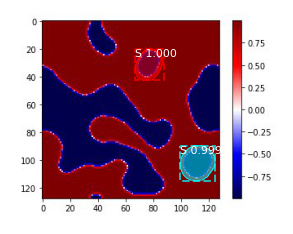

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


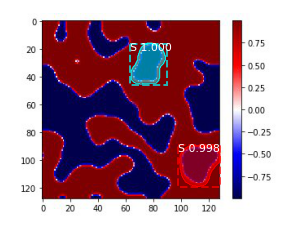

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


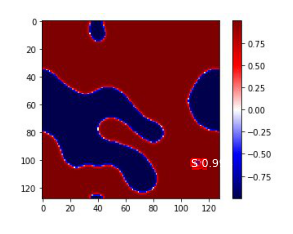

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


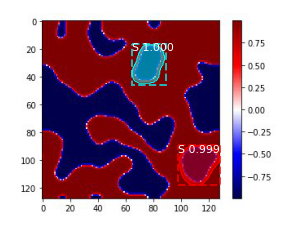

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


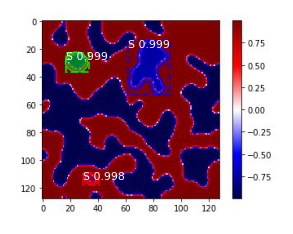

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


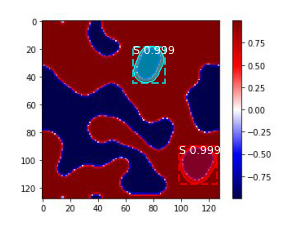

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


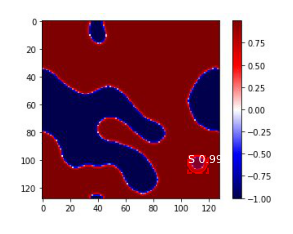

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


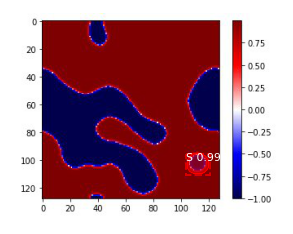

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


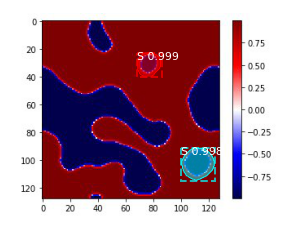

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


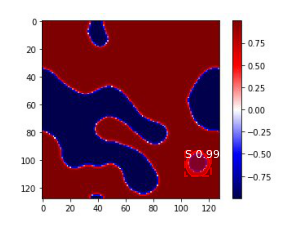

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


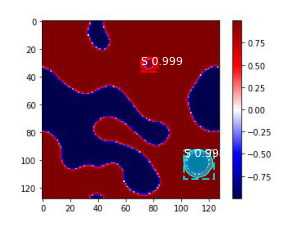

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


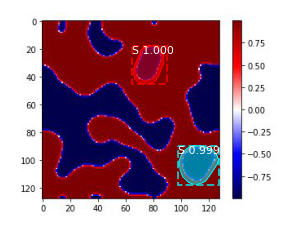

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32

*** No instances to display *** 



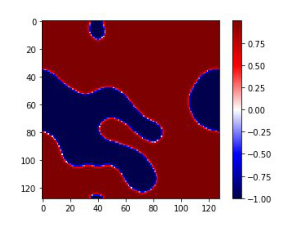

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


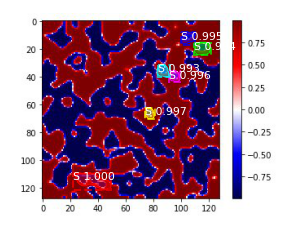

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


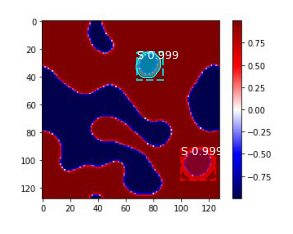

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


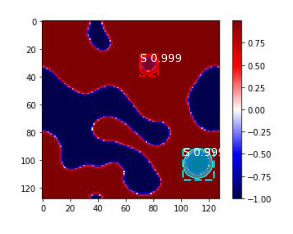

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


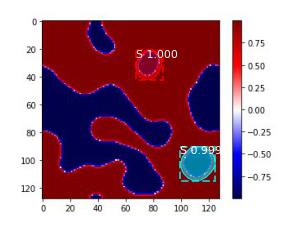

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


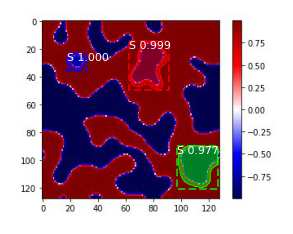

Processing 1 images
image                    shape: (252, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


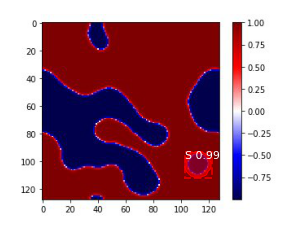

Processing 1 images
image                    shape: (251, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  323.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


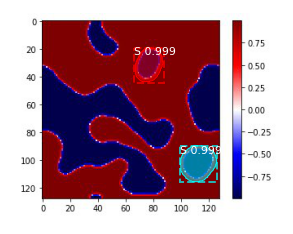

In [ ]:
import skimage
real_test_dir = '/content/Mask_RCNN/data/val/' #recomiendo usar archivos .jpg en el set de validación, en su momento me dio problemas ese detalle
image_paths = []

# Iteramos sobre los archivos en el directorio de pruebas reales
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        # Agregamos el archivo si tiene la extensión de imagen adecuada
        image_paths.append(os.path.join(real_test_dir, filename))

# Iteramos sobre cada imagen en la lista de imágenes
for image_path in image_paths:
    # Cargamos la imagen y la convertimos en una matriz numpy
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    # Ejecutamos la detección de objetos sobre la imagen usando el modelo entrenado
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    # Visualizamos los resultados de la detección en la imagen original
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))

#Aquí se realiza la detección para algunas imágenes. 